<a href="https://colab.research.google.com/github/evan-randall/DS-Unit-2-Applied-Modeling/blob/master/module4-model-interpretation/Copy_of_LS_DS_234_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


Lambda School Data Science

*Unit 2, Sprint 3, Module 4*

---

# Model Interpretation

You will use your portfolio project dataset for all assignments this sprint.

## Assignment

Complete these tasks for your project, and document your work.

- [ ] Continue to iterate on your project: data cleaning, exploratory visualization, feature engineering, modeling.
- [ ] Make at least 1 partial dependence plot to explain your model.
- [ ] Make at least 1 Shapley force plot to explain an individual prediction.
- [ ] **Share at least 1 visualization (of any type) on Slack!**

If you aren't ready to make these plots with your own dataset, you can practice these objectives with any dataset you've worked with previously. Example solutions are available for Partial Dependence Plots with the Tanzania Waterpumps dataset, and Shapley force plots with the Titanic dataset. (These datasets are available in the data directory of this repository.)

Please be aware that **multi-class classification** will result in multiple Partial Dependence Plots (one for each class), and multiple sets of Shapley Values (one for each class).

In [ ]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Applied-Modeling/master/data/'
    !pip install category_encoders==2.*
    !pip install eli5
    !pip install pdpbox
    !pip install shap

# If you're working locally:
else:
    DATA_PATH = '../data/'

### Continue to iterate on your project: data cleaning, exploratory visualization, feature engineering, modeling.

In [56]:
import pandas as pd
from google.colab import files
uploaded = files.upload()

Saving NBA Salaries - Sheet1 (9).csv to NBA Salaries - Sheet1 (9) (1).csv


In [57]:
df = pd.read_csv('NBA Salaries - Sheet1 (9).csv')
df.head(5)

,NAME,TEAM,POSITION,HEIGHT IN.,EXPERIENCE,SCORING AVERAGE,SALARY
0,Stephen Curry,Golden State Warriors,1,75,11,23.5,40200000
1,Chris Paul,Oklahoma City Thunder,1,73,15,18.5,38506482
2,Russell Westbrook,Houston Rockets,1,75,12,23.2,38506482
3,John Wall,Washington Wizards,1,76,10,19.0,38199000
4,Kevin Durant,Brooklyn Nets,3,82,13,27.0,38199000


In [58]:
import plotly.express as px
px.scatter(df, x='EXPERIENCE', y='SALARY', trendline='ols')

In [59]:
import pandas as pd

test = df[10:]
val = df[50:100]
train = df[:100]

In [60]:
# Assign to X, y
target = 'SALARY'
features = df.columns.drop('SALARY')

X_train = train[features]
y_train = train[target]

X_val = val[features]
y_val = val[target]

X_test = test[features]
y_test = test[target]

In [61]:
y_train.head()

0    40200000
1    38506482
2    38506482
3    38199000
4    38199000
Name: SALARY, dtype: int64

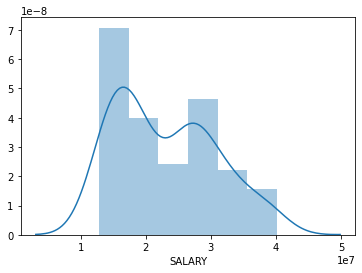

In [62]:
# The target has some right skew
%matplotlib inline
import seaborn as sns
sns.distplot(y_train);

### Fit Linear Regression model

In [63]:
import category_encoders as ce
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

# SCALE YOUR DATA

lr = make_pipeline(
    ce.TargetEncoder(),
    StandardScaler(),
    LinearRegression()
)

lr.fit(X_train, y_train)
print('Linear Regression R^2', lr.score(X_val, y_val))

Linear Regression R^2 -3.58374493020996


### Explaining Linear Regression

In [64]:
coefficients = lr.named_steps['linearregression'].coef_
pd.Series(coefficients, features)

NAME               0.000000e+00
TEAM               1.710512e+06
POSITION           2.912846e+05
HEIGHT IN.        -2.597898e+05
EXPERIENCE         4.418754e+05
SCORING AVERAGE    4.833458e+06
dtype: float64

### Fit Gradient Boosting model

In [65]:
from sklearn.metrics import r2_score
from xgboost import XGBRegressor

gb = make_pipeline(
    ce.OrdinalEncoder(),
    XGBRegressor(n_estimators=200, objective='reg:squarederror', n_jobs=-1)
)

gb.fit(X_train, y_train)
y_pred = gb.predict(X_val)
print('Gradient Boosting R^2', r2_score(y_val, y_pred))

Gradient Boosting R^2 0.999947864136576


### Explaining Gradient Boosting

Linear models have coefficients, but trees do not.

Instead, to see the relationship between individual feature(s) and the target, we can use partial dependence plots.

### Partial Dependence Plots with 1 feature

In [66]:
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 72

In [67]:
from pdpbox.pdp import pdp_isolate, pdp_plot

feature = 'EXPERIENCE'

isolated = pdp_isolate(
      model=gb,
      dataset=X_val,
      model_features=X_val.columns,
      feature=feature
)

(<Figure size 1080x684 with 2 Axes>,
 {'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f0167bdc908>,
  'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f018555a3c8>})

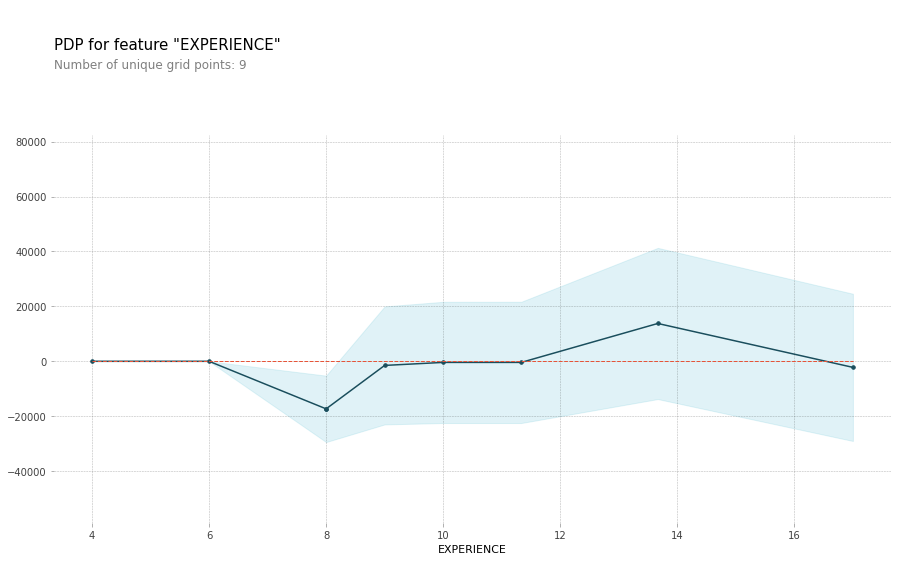

In [68]:
pdp_plot(isolated, feature_name=feature)

In [69]:
# This could be explained in a large salary change based on switching teams and signing a new contract

### Partial Dependence Plots with 2 features

In [72]:
from pdpbox.pdp import pdp_interact, pdp_interact_plot

features = ['SCORING AVERAGE', 'HEIGHT IN.']

interaction = pdp_interact(
    model=gb,
    dataset=X_val,
    model_features=X_val.columns,
    features=features
)

In [73]:
pdp_interact_plot

<function pdpbox.pdp.pdp_interact_plot>

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


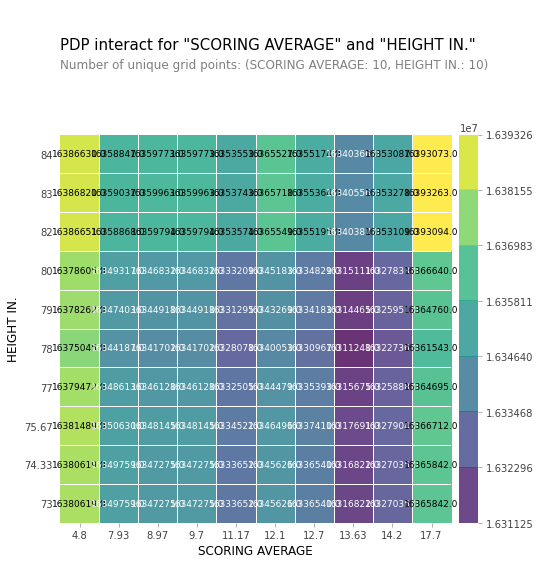

In [75]:
pdp_interact_plot(interaction, plot_type='grid', feature_names=features);

### Make at least 1 Shapley force plot to explain an individual prediction.

In [76]:
### Let’s do something similar, but with a tuned Random Forest and Shapley Values.

In [77]:
# Assign to X, y
features = ['POSITION', 'HEIGHT IN.', 'SCORING AVERAGE', 'EXPERIENCE']
target = 'SALARY'
X_train = train[features]
y_train = train[target]
X_test = test[features]
y_test = test[target]

In [78]:
from scipy.stats import randint, uniform
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV

param_distributions = { 
    'n_estimators': randint(50, 500), 
    'max_depth': [5, 10, 15, 20, None], 
    'max_features': uniform(0, 1), 
}

search = RandomizedSearchCV(
    RandomForestRegressor(random_state=42), 
    param_distributions=param_distributions, 
    n_iter=5, 
    cv=2, 
    scoring='neg_mean_absolute_error', 
    verbose=10, 
    return_train_score=True, 
    n_jobs=-1, 
    random_state=42
)

search.fit(X_train, y_train);

Fitting 2 folds for each of 5 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    3.4s finished


In [79]:
print('Best hyperparameters', search.best_params_)
print('Cross-validation MAE', -search.best_score_)
model = search.best_estimator_

Best hyperparameters {'max_depth': 20, 'max_features': 0.9507143064099162, 'n_estimators': 156}
Cross-validation MAE 12547389.509445317


In [80]:
# Get an individual observation to explain.
# For example, the 0th row from the test set.
row = X_test.iloc[[0]]
row

,POSITION,HEIGHT IN.,SCORING AVERAGE,EXPERIENCE
10,3,79,17.0,9


In [81]:
# What was the actual salary for this player?
y_test.iloc[[0]]

10    32742000
Name: SALARY, dtype: int64

In [82]:
# What does the model predict for this player?
model.predict(row)

array([30393439.12820513])

In [83]:
# Why did the model predict this?
# Look at a Shapley Values Force Plot
import shap

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(row)
shap.initjs()
shap.force_plot(
    base_value=explainer.expected_value,
    shap_values=shap_values,
    features=row
)

## Stretch Goals

#### Partial Dependence Plots
- [ ] Make multiple PDPs with 1 feature in isolation.
- [ ] Make multiple PDPs with 2 features in interaction. 
- [ ] Use Plotly to make a 3D PDP.
- [ ] Make PDPs with categorical feature(s). Use Ordinal Encoder, outside of a pipeline, to encode your data first. If there is a natural ordering, then take the time to encode it that way, instead of random integers. Then use the encoded data with pdpbox. Get readable category names on your plot, instead of integer category codes.

#### Shap Values
- [ ] Make Shapley force plots to explain at least 4 individual predictions.
    - If your project is Binary Classification, you can do a True Positive, True Negative, False Positive, False Negative.
    - If your project is Regression, you can do a high prediction with low error, a low prediction with low error, a high prediction with high error, and a low prediction with high error.
- [ ] Use Shapley values to display verbal explanations of individual predictions.
- [ ] Use the SHAP library for other visualization types.

The [SHAP repo](https://github.com/slundberg/shap) has examples for many visualization types, including:

- Force Plot, individual predictions
- Force Plot, multiple predictions
- Dependence Plot
- Summary Plot
- Summary Plot, Bar
- Interaction Values
- Decision Plots

We just did the first type during the lesson. The [Kaggle microcourse](https://www.kaggle.com/dansbecker/advanced-uses-of-shap-values) shows two more. Experiment and see what you can learn!

### Links

#### Partial Dependence Plots
- [Kaggle / Dan Becker: Machine Learning Explainability — Partial Dependence Plots](https://www.kaggle.com/dansbecker/partial-plots)
- [Christoph Molnar: Interpretable Machine Learning — Partial Dependence Plots](https://christophm.github.io/interpretable-ml-book/pdp.html) + [animated explanation](https://twitter.com/ChristophMolnar/status/1066398522608635904)
- [pdpbox repo](https://github.com/SauceCat/PDPbox) & [docs](https://pdpbox.readthedocs.io/en/latest/)
- [Plotly: 3D PDP example](https://plot.ly/scikit-learn/plot-partial-dependence/#partial-dependence-of-house-value-on-median-age-and-average-occupancy)

#### Shapley Values
- [Kaggle / Dan Becker: Machine Learning Explainability — SHAP Values](https://www.kaggle.com/learn/machine-learning-explainability)
- [Christoph Molnar: Interpretable Machine Learning — Shapley Values](https://christophm.github.io/interpretable-ml-book/shapley.html)
- [SHAP repo](https://github.com/slundberg/shap) & [docs](https://shap.readthedocs.io/en/latest/)